#### Qlunc tutorial by Francisco Costa
# **Tutorial 1**
## Qlunc step by step

This tutorial aims to facilitate the introduction to Qlunc. 
Will go through the code and create a lidar device with "optics" and "photonics" modules. Will ask for uncertainties either lidar general one or component specific uncertainty. We will see some graphical interesting results. Will see how to access  lidar design data. 

* **Some steps are not deeply explained since it is not necessary for the sake of this tutorial. The main goal of the tutorial is to show how the lidar digital twin is built and the interaction between different modules.**

Importing some packages is always needed:

In [1]:
import os
os.chdir('../')
# importing  uncertainty functions
import Utils.Qlunc_Help_standAlone as SA, UQ_Functions.UQ_Photonics_Classes as uphc,UQ_Functions.UQ_Optics_Classes as uopc, UQ_Functions.UQ_Power_Classes as upwc,UQ_Functions.UQ_Lidar_Classes as ulc, UQ_Functions.UQ_ProbeVolume_Classes as upbc,UQ_Functions.UQ_Data_processing_Classes as uprm
from Utils.Qlunc_ImportModules import *

### Qlunc inputs:  

A [.yml template](https://github.com/PacoCosta/Qlunc/blob/Qlunc-V0.9/Main/Template_yaml_inputs_file.yml) is included in the repository. To accomplish this tutorial a yaml file is already filled. 

The code below imports the `yaml` file.

In [2]:
# Obtain data from .yaml file:
with open (r'./Tutorials/yaml_inputs_file_1.yml','r') as file:
    Qlunc_yaml_inputs={}
    docs = yaml.load_all(file, Loader=yaml.FullLoader)
    for doc in docs:      
        for k, v in doc.items():     
            Qlunc_yaml_inputs.setdefault(k,v)

We obtain a dictionary, a well-known python object, with all the data introduced in the `yaml` file. Let´s have a look to the data:

In [3]:
Qlunc_yaml_inputs

{'Main_directory': './Tutorials',
 'Project': 'Gandia',
 'Components': {'Scanner': {'Name': 'Scanner_Yaml',
   'Origin': [0, 0, 0],
   'Pattern time': 20,
   'Single point measuring time': 2,
   'Lissajous parameters': [100, 50, 50, 3, 3],
   'Sample rate': 0,
   'Type': 'VAD',
   'Pattern': 'None',
   'stdv focus distance': 1,
   'stdv Cone angle': 2,
   'stdv Azimuth': 3,
   'Focus distance': [125],
   'Cone angle': [15],
   'Azimuth': [0, 360],
   'x': [160, 160, 160, 160],
   'y': [50, -50, -50, 50],
   'z': [46.21070722778538, 46.21070722778538, -46.21070722778537, -85],
   'Uncertainty function': 'uopc.UQ_Scanner'},
  'Optical Circulator': {'Name': 'OC_Yaml',
   'Insertion loss': 0.8,
   'SNR': 60,
   'Uncertainty function': 'uopc.UQ_OpticalCirculator'},
  'Telescope': {'Name': 'Telescope_YAML',
   'Aperture': 0.02,
   'Focal length': 0.5,
   'Fiber-lens distance': 0.0024,
   'Fiber-lens offset': 0.498,
   'Effective radius telescope': 0.0166,
   'Output beam radius': 0.02,
   'P

Now we have the component inputs, let's create them.

### **Creating the lidar classes**:

We create the python classes by running the Qlunc Core: `Qlunc_Classes.py`. Here we run a copy of `Qlunc_Classes.py` named `WorkingExample_Tutorial.py` created for the sake of this example.

In [4]:
# Execute Qlunc_Classes.py (creating classes for lidar 'objects'):
exec(open(Qlunc_yaml_inputs['Main_directory']+'/WorkingExample_Tutorial.py').read())

In [5]:
!dir
Qlunc_yaml_inputs['Main_directory']

 Volume in drive C has no label.
 Volume Serial Number is 0C54-9785

 Directory of C:\SWE_LOCAL\GIT_Qlunc

30.12.2021  11:54    <DIR>          .
30.12.2021  11:54    <DIR>          ..
08.12.2021  16:36    <DIR>          .github
30.12.2021  11:54               309 .gitignore
08.12.2021  16:36    <DIR>          .pylint.d
08.12.2021  16:36    <DIR>          Docs
29.11.2021  22:11               481 environment.yml
30.03.2021  01:01             1.566 LICENSE
03.01.2022  13:49    <DIR>          Main
03.01.2022  15:02    <DIR>          metadata
08.12.2021  16:36    <DIR>          Pictures_repo_
03.01.2022  15:02    <DIR>          Projects
29.11.2021  22:11             8.408 readme.md
08.12.2021  16:36    <DIR>          Sphinx4Qlunc
08.12.2021  16:36    <DIR>          TestFiles_Qlunc
03.01.2022  16:56    <DIR>          Tutorials
08.12.2021  16:36    <DIR>          UnderDevelopment
03.01.2022  16:58    <DIR>          UQ_Functions
30.12.2021  11:54    <DIR>          Utils
30.03.2021  01:01      

'./Tutorials'

The main directory is taken from the yaml file, as well as the rest of the lidar parameters, including plotting flags which states what we want to plot

### **Creating the lidar digital twin**:

We can now begin building up the lidar device and we will do it modularly. 
#### Scanner digital twin:
Will begin with the optics module and want to include in here two components: a scanner and an optical circulator, wich characteristics has been introduced in the yaml file.

Then, we can instance the class _scanner_ and the class _optical_circulator_ to build up an _optics_module_ wich, in turn, is created by instantiating the class _optics_module_.

Let's instantiate the class _scanner_ to "create" the scanner object:

In [6]:
# Instantiating scanner class to create a Scanner virtual-twin

Scanner           = scanner(name            = Qlunc_yaml_inputs['Components']['Scanner']['Name'],           # Introduce your scanner name.
                            scanner_type    = Qlunc_yaml_inputs['Components']['Scanner']['Type'],
                            origin          = Qlunc_yaml_inputs['Components']['Scanner']['Origin'],         # Origin (coordinates of the lidar deployment).
                            pattern         = Qlunc_yaml_inputs['Components']['Scanner']['Pattern'],
                            lissajous_param = Qlunc_yaml_inputs['Components']['Scanner']['Lissajous parameters'],
                            sample_rate     = Qlunc_yaml_inputs['Components']['Scanner']['Sample rate'],    # for now introduce it in [degrees].
                            time_pattern    = Qlunc_yaml_inputs['Components']['Scanner']['Pattern time'],
                            time_point      = Qlunc_yaml_inputs['Components']['Scanner']['Single point measuring time'],      
                           # This values for focus distance, cone_angle and azimuth define a typical VAD scanning sequence:
                               # I changed azimuth calculations because with "np.arange" we do not capture the last point in the pattern. "np.arange does not include the last point"; np.linspace capture all the points.
                               # Furthermore, once the time of the pattern is included in the pattern, we will do calculations based on the n° of points yielded by the ratio: time_pattern[sec]/time_point[sec/point]
                               # HAve to decide if wnat np.arange or np.linspace here (azimuth). If 360° is chosen for azimuth, np.arange works, but np.linspace doesn't
                            azimuth         = np.array(np.arange(Qlunc_yaml_inputs['Components']['Scanner']['Azimuth'][0],                                                  
                                                                  Qlunc_yaml_inputs['Components']['Scanner']['Azimuth'][1],
                                                                  math.floor((Qlunc_yaml_inputs['Components']['Scanner']['Azimuth'][1]-Qlunc_yaml_inputs['Components']['Scanner']['Azimuth'][0])/(Qlunc_yaml_inputs['Components']['Scanner']['Pattern time']/Qlunc_yaml_inputs['Components']['Scanner']['Single point measuring time'])))), # Azimuth angle in [degrees].
                            
                            # azimuth         = np.array(np.linspace(Qlunc_yaml_inputs['Components']['Scanner']['Azimuth'][0],                                                  
                            #                                         Qlunc_yaml_inputs['Components']['Scanner']['Azimuth'][1],
                            #                                         math.floor(Qlunc_yaml_inputs['Components']['Scanner']['Pattern time']/Qlunc_yaml_inputs['Components']['Scanner']['Single point measuring time']))), # Azimuth angle in [degrees].                                  
                            focus_dist      = np.tile(Qlunc_yaml_inputs['Components']['Scanner']['Focus distance'],(1,len(np.linspace(Qlunc_yaml_inputs['Components']['Scanner']['Azimuth'][0],                                                  
                                                                   Qlunc_yaml_inputs['Components']['Scanner']['Azimuth'][1],
                                                                   math.floor(Qlunc_yaml_inputs['Components']['Scanner']['Pattern time']/Qlunc_yaml_inputs['Components']['Scanner']['Single point measuring time'])))))[0],   # Focus distance in [meters]                                                                                                
                            cone_angle      = np.tile(Qlunc_yaml_inputs['Components']['Scanner']['Cone angle'],(1,len(np.linspace(Qlunc_yaml_inputs['Components']['Scanner']['Azimuth'][0],                                                  
                                                                   Qlunc_yaml_inputs['Components']['Scanner']['Azimuth'][1],
                                                                   math.floor(Qlunc_yaml_inputs['Components']['Scanner']['Pattern time']/Qlunc_yaml_inputs['Components']['Scanner']['Single point measuring time'])))))[0],   # Cone angle in [degrees].
                            x               = np.array(Qlunc_yaml_inputs['Components']['Scanner']['x']),
                            y               = np.array(Qlunc_yaml_inputs['Components']['Scanner']['y']),
                            z               = np.array(Qlunc_yaml_inputs['Components']['Scanner']['z']),
                            stdv_focus_dist = Qlunc_yaml_inputs['Components']['Scanner']['stdv focus distance'],                 # Focus distance standard deviation in [meters].
                            stdv_cone_angle = Qlunc_yaml_inputs['Components']['Scanner']['stdv Cone angle'],                 # Cone angle standard deviation in [degrees].
                            stdv_azimuth    = Qlunc_yaml_inputs['Components']['Scanner']['stdv Azimuth'],                 # Azimuth angle standard deviation in [degrees].
                            unc_func        = uopc.UQ_Scanner) #eval(Qlunc_yaml_inputs['Components']['Scanner']['Uncertainty function']) )    # here you put the function describing your scanner uncertainty. 


Created new scanner: Scanner_Yaml


The label "Yaml" in the name of the device informs us that the data was taken from a yaml file and not manually, instantiating the class in question.

#### Optical circulator digital twin:
Then we can create the optical circulator by instantiating the optical_circulator class as follows:

In [7]:
#Optical Circulator:

Optical_circulator = optical_circulator (name           = Qlunc_yaml_inputs['Components']['Optical Circulator']['Name'],       # Introduce your Optical circulator name.
                                         insertion_loss = Qlunc_yaml_inputs['Components']['Optical Circulator']['Insertion loss'],                        # In [dB]. Insertion loss parameters.
                                         SNR            = Qlunc_yaml_inputs['Components']['Optical Circulator']['SNR'], # [dB] SNR optical circulator
                                         unc_func       = uopc.UQ_OpticalCirculator) #eval(Qlunc_yaml_inputs['Components']['Optical Circulator']['Uncertainty function']))  # Function describing your scanner uncertainty.  Further informaion in "UQ_Optics_Classes.py" comments.



Created new optical circulator: OC_Yaml


We provide the code with the probe volume and wind field reconstruction characteristics:

In [8]:
Probe_Volume = probe_volume (name                       = Qlunc_yaml_inputs['Probe Volume']['Name'],
                             extinction_coef            = Qlunc_yaml_inputs['Probe Volume']['Extinction coeficient'],
                             unc_func                   = upbc.UQ_Probe_volume)


Class "Probe volume" created


In [9]:
WFR_M = wfr (name                 = Qlunc_yaml_inputs['WFR model']['Name'],
             reconstruction_model = Qlunc_yaml_inputs['WFR model']['Model'],
             unc_func             = uprm.UQ_WFR)

Selected wfr model: None terrain


#### Optics module digital twin: 
Then we create the optics module by puting all optic components created so far (_Scanner_ and _Optical_circulator_) together

In [10]:
# Optics Module:
Optics_Module =  optics (name               = Qlunc_yaml_inputs['Modules']['Optics Module']['Name'],     # Introduce your Optics Module name.
                         scanner            = Scanner, #eval(Qlunc_yaml_inputs['Modules']['Optics Module']['Scanner']),             # Scanner instance (in this example "Scanner") or "None". "None" means that you don´t want to include Scanner in Optics Module, either in uncertainty calculations.
                         optical_circulator = Optical_circulator ,#eval(Qlunc_yaml_inputs['Modules']['Optics Module']['Optical circulator']),  # Optical Circulator instance (in this example "Optical_circulator") or "None". "None" means that you don´t want to include Optical circulator in Optics Module, either in uncertainty calculations.
                         telescope          = None,                         
                         unc_func           = uopc.sum_unc_optics) #eval(Qlunc_yaml_inputs['Modules']['Optics Module']['Uncertainty function']))


Created new optic module: Optics_module_Yaml


We have already created the optics module. Following the same method we can create the rest of the components and modules by instantiating their corresponding classes.

#### Optical amplifier digital twin:
Let's create the photonics module. First we do instantiate its components namely, photodetector and optical amplifier.

In [11]:
Optical_Amplifier = optical_amplifier(name             = Qlunc_yaml_inputs['Components']['Optical Amplifier']['Name'],        # Introduce your scanner name.
                                      NoiseFig         = Qlunc_yaml_inputs['Components']['Optical Amplifier']['Optical amplifier noise figure'],          # In [dB]. Can introduce it as a table from manufactures (in this example the data is taken from Thorlabs.com, in section EDFA\Graps) or introduce a single well-known value
                                      OA_Gain          = Qlunc_yaml_inputs['Components']['Optical Amplifier']['Optical amplifier gain'],                         # In [dB]. (in this example the data is taken from Thorlabs.com, in section EDFA\Specs)
                                      OA_BW            = Qlunc_yaml_inputs['Components']['Optical Amplifier']['Optical amplifier BW'],
                                      Power_interval   = np.array(np.arange(Qlunc_yaml_inputs['Components']['Optical Amplifier']['Power interval'][0],
                                                                            Qlunc_yaml_inputs['Components']['Optical Amplifier']['Power interval'][1],
                                                                            Qlunc_yaml_inputs['Components']['Optical Amplifier']['Power interval'][2])),
                                      unc_func         = uphc.UQ_Optical_amplifier) #eval(Qlunc_yaml_inputs['Components']['Optical Amplifier']['Uncertainty function']))  # Function describing Optical Amplifier uncertainty. Further informaion in "UQ_Photonics_Classes.py" comments.


Created new optical amplifier: OA_Yaml


#### Photodetector digital twin:

In [12]:
# Instantiating Photodetector:
Photodetector    = photodetector(name             = Qlunc_yaml_inputs['Components']['Photodetector']['Name'],               # Introduce your photodetector name.
                                 Photo_BandWidth  = Qlunc_yaml_inputs['Components']['Photodetector']['Photodetector BandWidth'],                  # In[]. Photodetector bandwidth
                                 Load_Resistor    = Qlunc_yaml_inputs['Components']['Photodetector']['Load resistor'],                     # In [ohms]
                                 Photo_efficiency = Qlunc_yaml_inputs['Components']['Photodetector']['Photodetector efficiency'],                    # Photodetector efficiency [-]
                                 Dark_Current     = Qlunc_yaml_inputs['Components']['Photodetector']['Dark current'],                   #  In [A]. Dark current in the photodetector.
                                 Photo_SignalP    = Qlunc_yaml_inputs['Components']['Photodetector']['Photodetector signalP'],
                                 Power_interval   = np.array(np.arange(Qlunc_yaml_inputs['Components']['Photodetector']['Power interval'][0],
                                                                       Qlunc_yaml_inputs['Components']['Photodetector']['Power interval'][1],
                                                                       Qlunc_yaml_inputs['Components']['Photodetector']['Power interval'][2])),#np.arange(Qlunc_yaml_inputs['Components']['Photodetector']['Power interval']), # In [w]. Power interval for the photodetector domain in photodetector SNR plot. 
                                 Active_Surf      = Qlunc_yaml_inputs['Components']['Photodetector']['Active Surface'],
                                 Gain_TIA         = Qlunc_yaml_inputs['Components']['Photodetector']['Gain TIA'],                    # In [dB]. If there is a transimpedance amplifier.
                                 V_Noise_TIA      = Qlunc_yaml_inputs['Components']['Photodetector']['V Noise TIA'],                 # In [V]. If there is a transimpedance amplifier.
                                 
                                 unc_func         = uphc.UQ_Photodetector) #eval(Qlunc_yaml_inputs['Components']['Photodetector']['Uncertainty function']))  # Function describing Photodetector uncertainty. Further informaion in "UQ_Photonics_Classes.py" comments.



Created new photodetector: Photodetector_YAML


#### Photonics module digital twin:
And finally the Photonics module:

In [13]:
# Instantiating Photonics module:
Photonics_Module = photonics(name                    = Qlunc_yaml_inputs['Modules']['Photonics Module']['Name'],        # Introduce your Photonics module name
                             photodetector           = Photodetector, #eval(Qlunc_yaml_inputs['Modules']['Photonics Module']['Photodetector']),             # Photodetector instance (in this example "Photodetector") or "None". "None" means that you don´t want to include photodetector in Photonics Module, either in uncertainty calculations.
                             optical_amplifier       = Optical_Amplifier, #'None',##eval(Qlunc_yaml_inputs['Modules']['Photonics Module']['Optical amplifier']),         # Scanner instance (in this example "OpticalAmplifier") or "None". "None" means that you don´t want to include Optical Amplifier in Photonics Module, either in uncertainty calculations.
                             laser                   = 'None', #Laser,
                             acousto_optic_modulator = 'None', #AOM,
                             unc_func                = uphc.sum_unc_photonics) #eval(Qlunc_yaml_inputs['Modules']['Photonics Module']['Uncertainty function']))


Created new photonic module: Photonics_module_Yaml


#### Lidar general inputs:

In [14]:
# Instantiating lidar general inputs
Lidar_inputs     = lidar_gral_inp(name        = Qlunc_yaml_inputs['Components']['Lidar general inputs']['Name'],      # Introduce the name of your lidar data folder.
                                  wave        = Qlunc_yaml_inputs['Components']['Lidar general inputs']['Wavelength'],                    # In [m]. Lidar wavelength.
                                  ltype       = Qlunc_yaml_inputs['Components']['Lidar general inputs']['Type'],
                                  yaw_error   = Qlunc_yaml_inputs['Components']['Lidar general inputs']['Yaw error'],                          # In [°]. Degrees of rotation around z axis because of inclinometer errors
                                  pitch_error = Qlunc_yaml_inputs['Components']['Lidar general inputs']['Pitch error'],                          # In [°]. Degrees of rotation around y axis
                                  roll_error  = Qlunc_yaml_inputs['Components']['Lidar general inputs']['Roll error'],                        # In [°]. Degrees of rotation around z axis.
                                  dataframe   = { })  # Final dataframe


Created new lidar general inputs: Lidar_gral_inputs_Yaml


#### Atmospheric scenarios:
We can create different atmospheric scenarios under which the lidar uncertainties are assessed. Thus, single or multiple scenarios can be evaluated either including single or time-seried atmospheric variables values.

In [15]:
# Instantiating atmospheric scenario(s):
Atmospheric_TimeSeries = Qlunc_yaml_inputs['Atmospheric_inputs']['TimeSeries']  
                                                                           
if Atmospheric_TimeSeries:
    Atmos_TS_FILE           = '../metadata/AtmosphericData/'+Qlunc_yaml_inputs['Atmospheric_inputs']['Atmos_TS_FILE']
    AtmosphericScenarios_TS = pd.read_csv(Atmos_TS_FILE,delimiter=';',decimal=',')
    Atmospheric_inputs = {
                          'temperature' : list(AtmosphericScenarios_TS.loc[:,'T']),    
                          'humidity'    : list(AtmosphericScenarios_TS.loc[:,'H']),    
                          'rain'        : list(AtmosphericScenarios_TS.loc[:,'rain']),
                          'fog'         : list(AtmosphericScenarios_TS.loc[:,'fog']),
                          'time'        : list(AtmosphericScenarios_TS.loc[:,'t'])     
                          } 
    Atmospheric_Scenario = atmosphere(name        = 'Atmosphere1',
                                      temperature = Atmospheric_inputs['temperature'])
else:    

    Atmospheric_Scenario = atmosphere(name        = 'Atmosphere1',
                                      temperature = Qlunc_yaml_inputs['Atmospheric_inputs']['Temperature'])

Created new atmosphere: Atmosphere1


#### Lidar digital twin:
Putting all python objects together, like a puzzle, we make up a lidar digital twin. This enable assessing lidar uncertainties before a lidar is manufactured:

In [16]:
# Instantiating lidar device:
Lidar = lidar(name           = Qlunc_yaml_inputs['Lidar']['Name'],                       # Introduce the name of your lidar device.
              photonics      = Photonics_Module, #eval(Qlunc_yaml_inputs['Lidar']['Photonics module']),     # Introduce the name of your photonics module.
              optics         = Optics_Module, #eval(Qlunc_yaml_inputs['Lidar']['Optics module']),        # Introduce the name of your optics module.
              power          = None, #eval(Qlunc_yaml_inputs['Lidar']['Power module']),         # Introduce the name of your power module. NOT IMPLEMENTED YET!
              wfr_model      = WFR_M,
              filt_method    = None,
              probe_volume   = Probe_Volume, 
              lidar_inputs   = Lidar_inputs, #eval(Qlunc_yaml_inputs['Lidar']['Lidar inputs']),         # Introduce lidar general inputs
              unc_func       = ulc.sum_unc_lidar) #eval(Qlunc_yaml_inputs['Lidar']['Uncertainty function'])) # Function estimating lidar global uncertainty


Created new lidar device: Caixa1


### **Calculating errors**:
Now we can ask for the error we are interested in. The modularity of the code allows us to ask separately either for a specific component or module uncertainty, or the global lidar uncertainty. 

As an example, we can ask for the optical amplifier uncertainty contribution. The uncertainty value is stored in *OpticalAmplifier_uncertainty*:

In [17]:
OpticalAmplifier_uncertainty,OpticalAmplifier_df = Lidar.photonics.optical_amplifier.Uncertainty(Lidar,Atmospheric_Scenario,cts,Qlunc_yaml_inputs)
# print(OpticalAmplifier_df)
print(OpticalAmplifier_uncertainty)

{'Uncertainty_OpticalAmp': [array([-24.5645152])], 'OSNR': array([       -inf, -5.4374729 , -2.42717294, -0.66626035,  0.58312701,
        1.55222714,  2.3440396 ,  3.0135075 ,  3.59342697,  4.1049522 ,
        4.5625271 ,  4.97645395,  5.35433956,  5.70196062,  6.02380746,
        6.32343969,  6.60372693,  6.86701631,  7.11525215,  7.35006311,
        7.57282706,  7.78472005,  7.98675391,  8.17980546,  8.36463952,
        8.54192719,  8.71226058,  8.87616474,  9.03410741,  9.18650708,
        9.33373965,  9.47614404,  9.61402688,  9.7476665 ,  9.87731627,
       10.00320754, 10.12555211, 10.24454434, 10.36036307, 10.47317317,
       10.58312701, 10.69036567, 10.79502   , 10.89721166, 10.99705387,
       11.09465224, 11.19010542, 11.28350568, 11.37493947, 11.4644879 ,
       11.55222714, 11.63822886, 11.72256054, 11.8052858 , 11.8864647 ,
       11.966154  , 12.04440737, 12.12127566, 12.19680704, 12.27104722,
       12.3440396 , 12.41582545, 12.486444  , 12.5559326 , 12.62432684,
     

C:\SWE_LOCAL\GIT_Qlunc\UQ_Functions\UQ_Photonics_Classes.py:163: RuntimeWarning: divide by zero encountered in log10
  OSNR_plot = 10*np.log10(((Lidar.photonics.optical_amplifier.Power_interval)/(NF_w*cts.h*(cts.c/Lidar.lidar_inputs.Wavelength)*Lidar.photonics.optical_amplifier.OA_BW))/1000)


In [18]:
Photonics_Uncertainty,Photonics_df = Lidar.photonics.Uncertainty(Lidar,Atmospheric_Scenario,cts,Qlunc_yaml_inputs)
print(Photonics_df)

There is NO TIA component in the photodetector
You didn´t include a laser in the lidar,so that laser uncertainty contribution is not in lidar uncertainty estimations.
{'Optical Amplifier': array([-24.5645152]), 'Photodetector': array([-121.72540351]), 'Photonics Module': array([-24.5645152])}


Or,  eventually we can ask for the lidar global uncertainty, where uncertainties coming from the different lidar modules are taken into account and combined following GUM suggestions:

Processing lidar uncertainties...
There is NO TIA component in the photodetector
You didn´t include a laser in the lidar,so that laser uncertainty contribution is not in lidar uncertainty estimations.
> c:\swe_local\git_qlunc\uq_functions\uq_optics_classes.py(65)UQ_Scanner()
     63     # pdb.set_trace()
     64     # R: Implement error in deployment of the tripod as a rotation over yaw, pitch and roll
---> 65     stdv_yaw    = np.array(np.deg2rad(Lidar.lidar_inputs.yaw_error_dep))
     66     stdv_pitch  = np.array(np.deg2rad(Lidar.lidar_inputs.pitch_error_dep))
     67     stdv_roll   = np.array(np.deg2rad(Lidar.lidar_inputs.roll_error_dep))

ipdb> c
> c:\swe_local\git_qlunc\uq_functions\uq_probevolume_classes.py(56)UQ_Probe_volume()
     54         pdb.set_trace()
     55         # Saving rayleigh length to a file in ./metadata to be read by matlab
---> 56         if os.path.isfile('./metadata/rayleigh_distance.txt'):
     57             os.remove('./metadata/rayleigh_distance.txt')

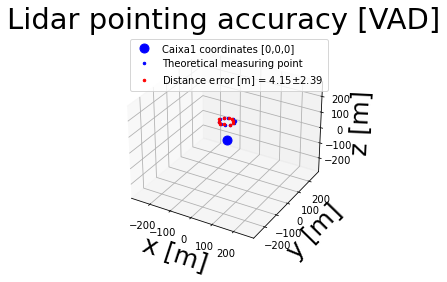

In [19]:
Lidar_Uncertainty = Lidar.Uncertainty(Lidar,Atmospheric_Scenario,cts,Qlunc_yaml_inputs)
print(Lidar_Uncertainty)

## Parameters access - dot notation

If want to access some parameter, follow dot notation. It can be done in two ways:

Either invoking the lidar object instance:
> Lidar.optics.scanner.focus_dist

or the component specific instance:

> Scanner.focus_distance

Let's see some examples:

### *Focus distance*

In [20]:
print(Scanner.focus_dist)

[125 125 125 125 125 125 125 125 125 125]


In [21]:
print(Lidar.optics.scanner.focus_dist)

[125 125 125 125 125 125 125 125 125 125]


### Optical circulator *insertion loss*

In [22]:
print(Optical_circulator.insertion_loss)

0.8


### Optical circulator *ID*

In [23]:
print(Optical_circulator.Optical_CirculatorID)

OC_Yaml


### Optical amplifier gain

In [24]:
Lidar.photonics.optical_amplifier.OA_Gain

30